# Accessing Planmap Geodata server

In this notebook we will access Planmap's data published through OGC services provided by the project.
The services are provided by an instance of Geoserver, which we will access here using public, open source Python libraries.

We are going to query WMS and WFS services and then visualize and investigate some properties of the data and software at hand. 

Planmap's Geoserver is available at https://geoserver.planmap.eu.

In [1]:
PLANMAP = 'https://geoserver.planmap.eu'
PLANMAP_WMS = PLANMAP + '/wms'
PLANMAP_WFS = PLANMAP + '/wfs'

In [2]:
import owslib
import geopandas

## WFS

In [3]:
from owslib.wfs import WebFeatureService

pm_wfs = WebFeatureService(PLANMAP_WFS)

In [4]:
list(pm_wfs.contents)

['mercury:H05_contacts_EPSG4326',
 'mercury:H05_geological_units_3_classes_EPSG4326',
 'mercury:H05_geological_units_5_classes_EPSG4326',
 'mercury:H05_linear_features_EPSG4326',
 'mercury:H05_surface_features_EPSG4326',
 'moon:PM-MOO-MS-SPAApollo_01.EPSG4326']

In [5]:
mercury_surf = pm_wfs.getfeature(typename=['mercury:H05_surface_features_EPSG4326'], outputFormat='json')

In [6]:
import geopandas as gpd
import json

mercury_surf_json = json.loads(mercury_surf.getvalue())

gdf = gpd.GeoDataFrame.from_features(mercury_surf_json['features'])

gdf.plot(figsize=(12,9));

## WMS

In [7]:
from owslib.wms import WebMapService

pm_wms = WebMapService(PLANMAP_WMS)

Version of the WMS interface we are going to use:

In [8]:
pm_wms.version

'1.1.1'

### Planmap's WMS content

In [9]:
list(pm_wms.contents)

['mercury:H05_contacts_EPSG4326',
 'mercury:H05_geological_units_3_classes_EPSG4326',
 'mercury:H05_geological_units_5_classes_EPSG4326',
 'mercury:H05_linear_features_EPSG4326',
 'mercury:H05_surface_features_EPSG4326',
 'mars:Mars_global_color_Viking.EPSG4326',
 'moon:PM-MOO-MS-SPAApollo_01.EPSG4326',
 'mercury:mercury_global_MD3Color_665m_EPSG4326',
 'moon:moon_global_color_lola_bluesteel.EPSG4326']

The data provided by a WMS service is accessed through the `GetMap` service:

In [10]:
for op in pm_wms.operations:
    print(op.name)

GetCapabilities
GetMap
GetFeatureInfo
DescribeLayer
GetLegendGraphic
GetStyles


#### Accessing Mercury's 5-classes geological units

In [11]:
mercury_5cc_wms = pm_wms['mercury:H05_geological_units_5_classes_EPSG4326']
mercury_5cc_wms.name

'mercury:H05_geological_units_5_classes_EPSG4326'

In [12]:
mercury_5cc_wms.boundingBox

(-4.0573446e-09,
 22.49999999818148,
 90.0000000036052,
 65.00002265337979,
 'EPSG:4326')

In [13]:
bbox = [round(v,1) for v in mercury_5cc_wms.boundingBoxWGS84]
bbox

[-0.0, 22.5, 90.0, 65.0]

In [14]:
mercury_5cc_data = pm_wms.getmap(layers = [mercury_5cc_wms.name],
                                 srs = 'EPSG:4326',
                                 size = (800,600),
                                 bbox = bbox,
                                 format = 'image/png')

The response from the WMS service is in _bytes_, we may write it down to a file or display it with `matplotlib` for instance.

In [15]:
with open('mercury_5cc.png', 'wb') as fp:
    fp.write(mercury_5cc_data.read())

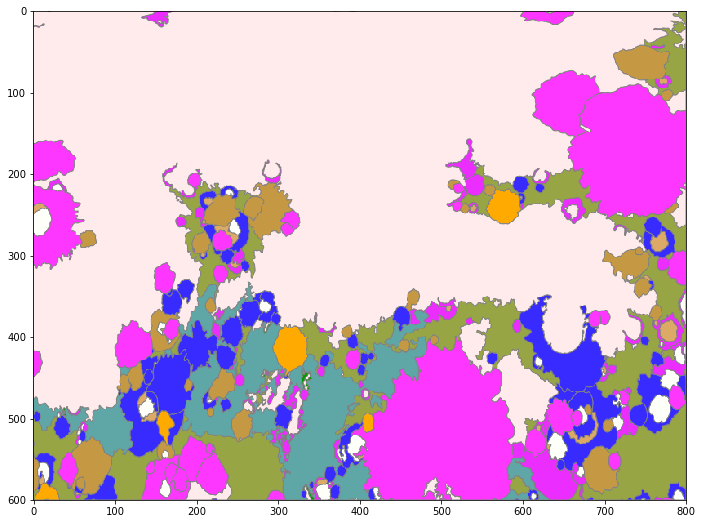

In [16]:
from matplotlib import pyplot as plt
import io

mercury_5cc_img = plt.imread(io.BytesIO(mercury_5cc_data.read()))

fig = plt.figure(figsize=(12,9))
plt.imshow(mercury_5cc_img)
plt.show()

This is very much out of context, that axis are not showing the geographic location and we don't have the planet in the background to help us understand what are these features.

#### Download Mercury basemap

In [17]:
basemap_data = pm_wms.getmap(layers=['mercury:mercury_global_MD3Color_665m_EPSG4326'],
                             size=(800, 600),
                             srs='EPSG:4326',
                             format='image/png',
                             bbox=bbox)

basemap_img = plt.imread(io.BytesIO(basemap_data.read()))

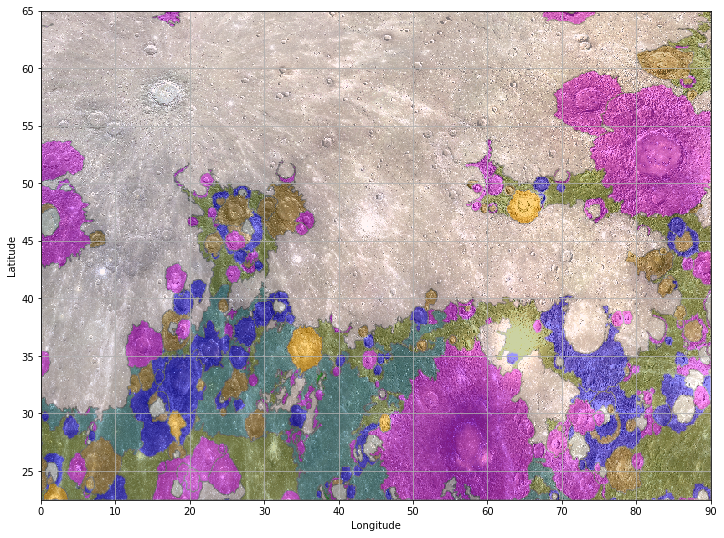

In [18]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()

extent = [bbox[i] for i in [0,2,1,3]]

ax.imshow(basemap_img, extent=extent, aspect='auto')

ax.imshow(mercury_5cc_img, extent=extent, aspect='auto', alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

Putting them all together:

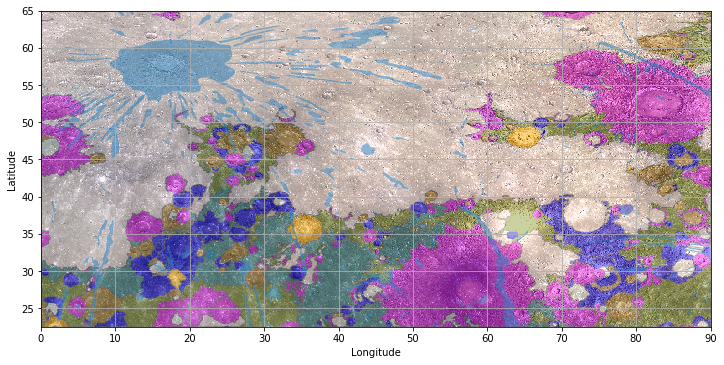

In [19]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()

extent = [bbox[i] for i in [0,2,1,3]]

ax.imshow(basemap_img, extent=extent, aspect='auto')

ax.imshow(mercury_5cc_img, extent=extent, aspect='auto', alpha=0.5)

gdf.plot(ax=ax, alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)